# Tutorial de Dynamic Topic Models (Conferencia EVIC2019 - en el contexto del estallido social en Chile)

# 1. Definición del Dataset y de sus _Slices_

In [1]:
import pandas as pd
from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

La carpeta _datasets_ contiene un archivo CSV llamado 'dataset_eldinamo_13122019.csv'. Corresponde a un dataset de noticias del medio "El Dinamo" entre el 4 de octubre 2019 y el 13 de diciembre 2019.

In [2]:
dataset="datasets/dataset_eldinamo_13122019.csv"
df = pd.read_csv(dataset)
df[:5]

,url,date,text
0,https://www.eldinamo.cl/nacional/2019/12/13/mo...,13 de Diciembre de 2019,El ministro de Vivienda Cristián Monckeberg ...
1,https://www.eldinamo.cl/nacional/2019/12/13/go...,13 de Diciembre de 2019,La Moneda informó que Sebastián Piñera decretó...
2,https://www.eldinamo.cl/nacional/2019/12/13/co...,13 de Diciembre de 2019,La Corte de apelaciones de Santiago declaró ad...
3,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Luego que durante esta mañana la Organización ...
4,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Tras varias semanas de espera la misión de ob...


In [3]:
print("Número de documentos: "+str(df.count()[0]))

Número de documentos: 453


Cambiamos el formato de las fechas para poder utilizar la información más facilmente.

In [4]:
#Modificar la columna "date" para que sea reconocida como fecha y no como texto.
df['date']= df['date'].replace(" de Diciembre de ", "/12/",regex=True)
df['date']= df['date'].replace(" de Noviembre de ", "/11/",regex=True)
df['date']= df['date'].replace(" de Octubre de ", "/10/",regex=True) 
df['date'] =pd.to_datetime(df['date'],format="%d/%m/%Y").dt.date

Para definir cómo dividir el dataset en distintos periodos de tiempo, miremos primero cuántos documentos tenemos y cómo se distribuyen en el tiempo:

In [5]:
#Contar el número de documentos por fecha
query="""SELECT date as fecha,count(*) as documentos
FROM df GROUP BY date;"""
result=sqldf(query)
result

,fecha,documentos
0,2019-10-04,2
1,2019-10-05,3
2,2019-10-06,3
3,2019-10-07,8
4,2019-10-08,5
...,...,...
66,2019-12-09,6
67,2019-12-10,6
68,2019-12-11,8
69,2019-12-12,7


En este ejemplo, divideremos los datos en cinco segmentos de dos semanas:

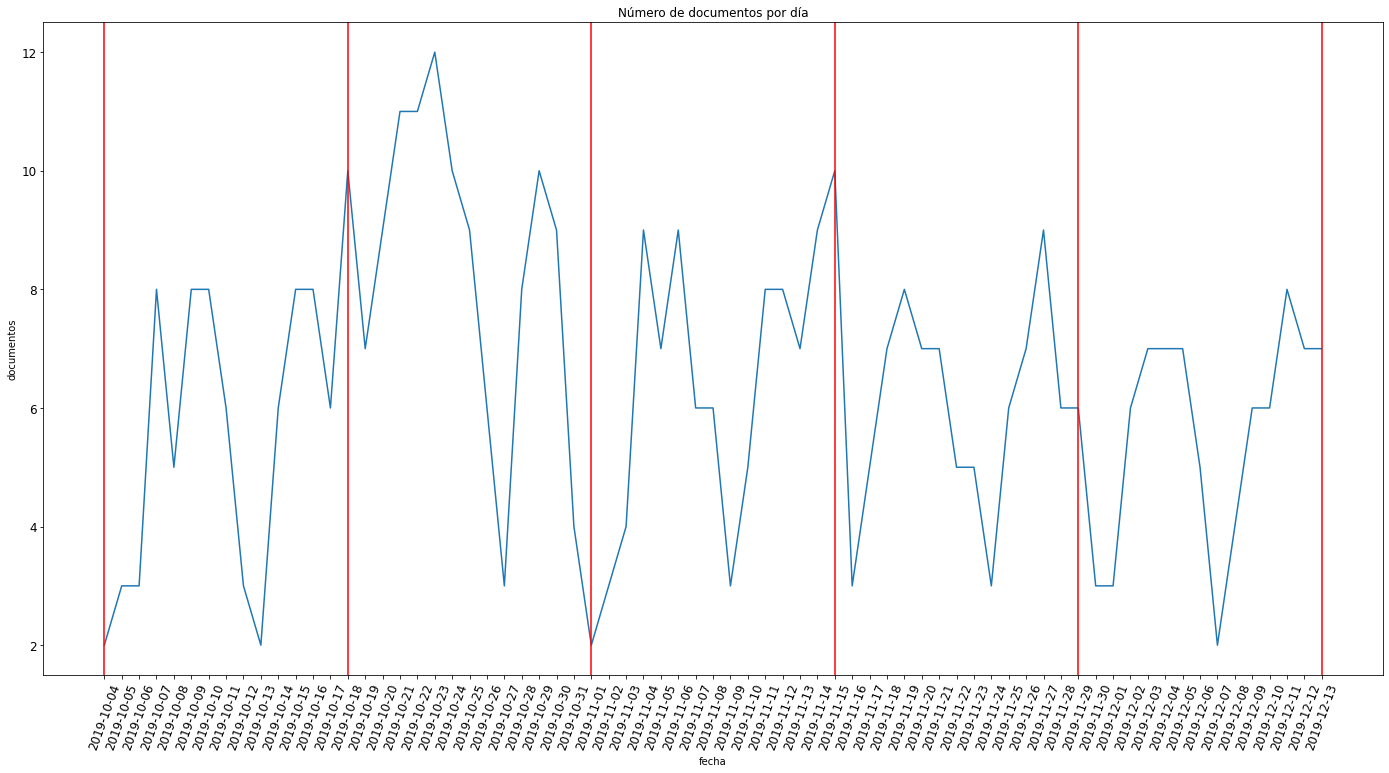

In [6]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['figure.figsize'] = [24, 12]

time_plot = sns.lineplot(x='fecha',
                         y='documentos',
                         data=result
                         ).set_title('Número de documentos por día')
plt.xticks(rotation=70)
plt.tick_params(labelsize=12)

plt.axvline(x='2019-10-04',color='red')
plt.axvline(x='2019-10-18',color='red')
plt.axvline(x='2019-11-01',color='red')
plt.axvline(x='2019-11-15',color='red')
plt.axvline(x='2019-11-29',color='red')
plt.axvline(x='2019-12-13',color='red')

plt.show()

In [7]:
q="""SELECT 'Week 1',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-10-04" AND "2019-10-17"
UNION
SELECT 'Week 2',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-10-18" AND "2019-10-31"
UNION
SELECT 'Week 3',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-01" AND "2019-11-15"
UNION
SELECT 'Week 4',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-16" AND "2019-11-29"
UNION
SELECT 'Week 5',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-30" AND "2019-12-13"
;"""
result=sqldf(q)
result

,'Week 1',Number of documents
0,Week 1,76
1,Week 2,119
2,Week 3,96
3,Week 4,84
4,Week 5,78


Para identificar los _slices_, conservamos el número de documentos por cada segmento:

In [8]:
index_slices=[76,119,96,84,78]

# 2. Preprocesamientos: filtrar palabras según categoría gramatical y/o extraer palabras claves

In [9]:
import spacy
nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )

In [10]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [15]:
def getKeywords(dataFrame,columnName):
    
    for index,rows in dataFrame.iterrows():
        
        text=rows[columnName]
        
        filteredText=""
        
        tokens = nlp(text)
        
        for token in tokens:
            if token.pos_ == "NOUN" :
                filteredText=filteredText+","+str(token.text.lower().strip())
                
        matches = matcher(tokens)
        for mach_id, start, end in matches:
            span = tokens[start:end]
            filteredText=filteredText+","+str(span.text.lower().strip())
                
        dataFrame.loc[index,'keywords']=filteredText

In [16]:
%%time
getKeywords(df,"text")

CPU times: user 9.2 s, sys: 19.7 ms, total: 9.22 s
Wall time: 9.22 s


In [17]:
df[:5]

,url,date,text,keywords
0,https://www.eldinamo.cl/nacional/2019/12/13/mo...,2019-12-13,El ministro de Vivienda Cristián Monckeberg ...,",ministro,investigación,cabo,caso,corrupción,i..."
1,https://www.eldinamo.cl/nacional/2019/12/13/go...,2019-12-13,La Moneda informó que Sebastián Piñera decretó...,",días,accidente,saldo,víctimas,mensaje,apoyo,s..."
2,https://www.eldinamo.cl/nacional/2019/12/13/co...,2019-12-13,La Corte de apelaciones de Santiago declaró ad...,",apelaciones,querella,intendente,contra,dirige..."
3,https://www.eldinamo.cl/nacional/2019/12/13/in...,2019-12-13,Luego que durante esta mañana la Organización ...,",mañana,informe,situación,derechos,estallido,r..."
4,https://www.eldinamo.cl/nacional/2019/12/13/in...,2019-12-13,Tras varias semanas de espera la misión de ob...,",semanas,espera,misión,observadores,informe,es..."


In [18]:
df["keywords"][1]

',días,accidente,saldo,víctimas,mensaje,apoyo,solidaridad,familiares,víctimas,tragedia,comunicado,sábado,domingo,diciembre,días,asta,bandera,sedes,dependencias,reparticiones,unidades,actos,carácter,festejo,último,personas,instituciones,medida,jueves,hallazgo,resto,pasajeros,avión,partes,aeronave,labores,búsqueda,horas,finalidad,cuerpos,víctimas,información,causas,tragedia,víctimas fatales,mensaje de apoyo,bandera nacional,dependencias de reparticiones,reparticiones públicas,carácter de festejo,instituciones particulares,hallazgo de resto,aeronave accidentada,labores de búsqueda'

# 4. Representación vectorial de los documentos

Utilizaremos la columna "keywords" como simplificación de los documentos.

In [20]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

documents=list(df['keywords'])
documents=[x.split(",") for x in documents]

dictionary = Dictionary(documents)

#dictionary.filter_extremes(no_below=0,no_above=0.99)

dictionary.filter_n_most_frequent(1)

corpus = [dictionary.doc2bow(doc) for doc in documents] 

model = TfidfModel(corpus)

vectorizedCorpus = model[corpus]

In [21]:
documents

[['',
  'ministro',
  'investigación',
  'cabo',
  'caso',
  'corrupción',
  'interior',
  'cartera',
  'situación',
  'grupo',
  'funcionarios',
  'departamento',
  'licitaciones',
  'pagos',
  'proveedores',
  'sociedades',
  'servicios',
  'ministerios',
  'comisiones',
  'contratos',
  'marzo',
  'hechos',
  'administración',
  '2014',
  '2019',
  'personas',
  'sábado',
  'disposición',
  'caso',
  'ministro',
  'hechos',
  'ministró',
  'fiscal',
  'información',
  'detalle',
  'diligencias',
  'respecto',
  'investigaciones',
  'delitos',
  'funcionarios',
  'compras',
  'equipos',
  'licencias',
  'software',
  'perjuicio',
  'familias',
  'secretario',
  'resultados',
  'cuenta',
  'personas',
  'ministerio',
  'personas',
  'determinaciones',
  'fiscal',
  'funcionarios',
  'proceso',
  'compras',
  'delitos',
  'temas',
  'compra',
  'computadores',
  'licencias',
  'software',
  'paralelo',
  'personas',
  'funcionarios',
  'reparticiones',
  'ministerios',
  'ministro',
  

## 3. Optimización de modelos de tópicos dinámicos

Entrenamos modelos con k_topics entre 5 y 12, y guardamos los modelos en archivos.

In [22]:
DTM_models=[]

In [23]:
%%time
from IPython.display import Audio
import numpy as np

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath

import time

k_topics=5

for i in range(8):
    print(i)
    init=time.time()

    s=time.time()

    ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=index_slices, 
                                 num_topics=k_topics+i,
                                 chain_variance=0.3,
                                 alphas=0.9,
                                 passes=10,
                                 chunksize=24000,
                                 em_min_iter=6,
                                 em_max_iter=15)

    DTM_models.append(ldaseq)

    e=time.time()
    print(str(k_topics+i)+" Topics - Tiempo necesario para la optimización del modelo:",(e-s))

    end=time.time()
    #print(end-init)
    
    #se guarda el modelo
    path_of_model = datapath("/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_"+str(k_topics+i)+"_topics")
    print(path_of_model)
    ldaseq.save(path_of_model)

0


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


5 Topics - Tiempo necesario para la optimización del modelo: 385.1943156719208
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_5_topics
1


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


6 Topics - Tiempo necesario para la optimización del modelo: 453.2893121242523
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_6_topics
2


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


7 Topics - Tiempo necesario para la optimización del modelo: 515.242757320404
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_7_topics
3


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


8 Topics - Tiempo necesario para la optimización del modelo: 553.0048134326935
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_8_topics
4


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


9 Topics - Tiempo necesario para la optimización del modelo: 654.5713069438934
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_9_topics
5


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


10 Topics - Tiempo necesario para la optimización del modelo: 649.8865489959717
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_10_topics
6


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


11 Topics - Tiempo necesario para la optimización del modelo: 685.7646956443787
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_11_topics
7


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


12 Topics - Tiempo necesario para la optimización del modelo: 756.3038401603699
/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/model_12_topics
CPU times: user 1h 17min 29s, sys: 4.8 s, total: 1h 17min 34s
Wall time: 1h 17min 33s


# 4. Evaluación de los modelos

In [24]:
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath

PATH="/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/"

from gensim.models import LdaSeqModel

k_topics=5

model_coherences=list()

for i in range(8):
    path_of_model = datapath(PATH+"model_"+str(k_topics+i)+"_topics")
    ldaseq = LdaSeqModel.load(path_of_model)
    
    coherenceValues=list()
    for time_fragment in range(5):
        topics_wrapper = ldaseq.dtm_coherence(time=time_fragment)
        cm_wrapper_cv = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_v')
        coherenceValues.append(cm_wrapper_cv.get_coherence())
    
    averageCoherenceValue = sum(coherenceValues) / len(coherenceValues) 
    model_coherences.append(averageCoherenceValue)

In [25]:
model_coherences

[0.37128090529668584,
 0.3345500833622054,
 0.32682282447305094,
 0.3450158735297677,
 0.33810605082096123,
 0.3222411148702362,
 0.34669298829613354,
 0.3505168102397341]

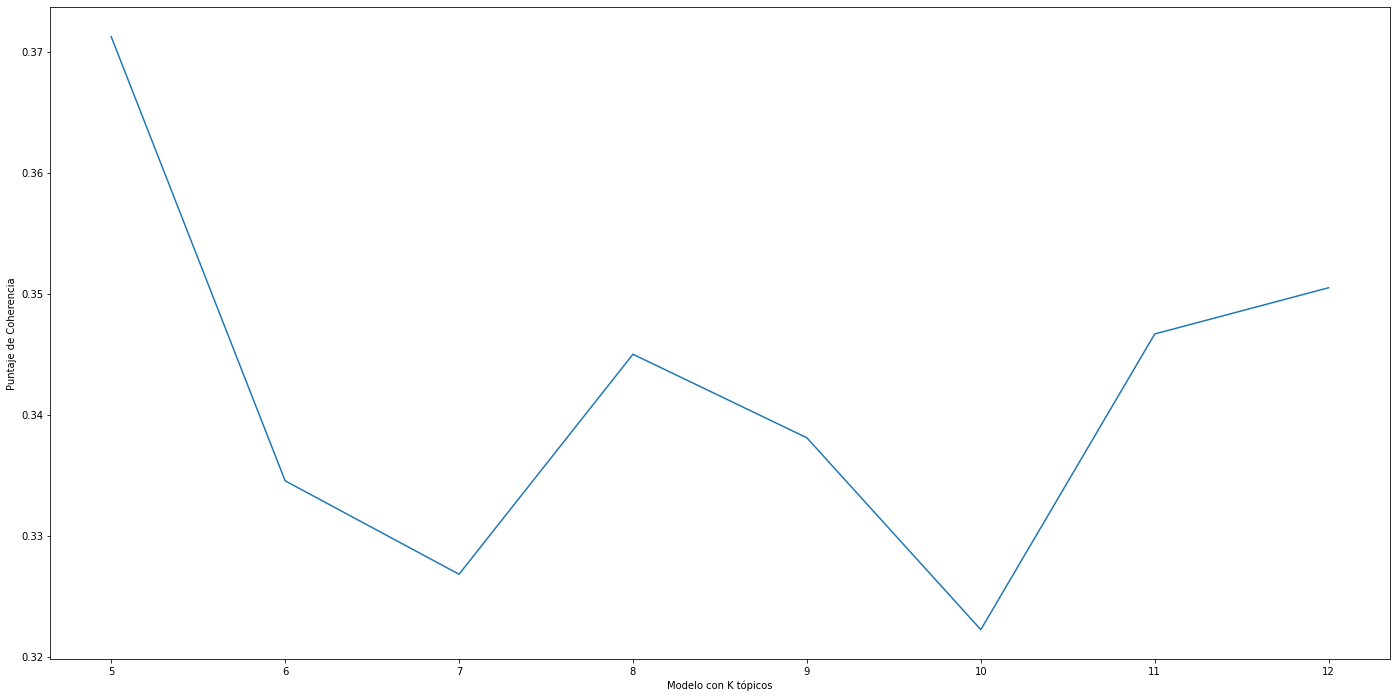

In [26]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np

xvalues=["5","6","7","8","9","10","11","12"]

df_fig1=pd.DataFrame({'xvalues': xvalues, 'yvalues': model_coherences })

fig, ax = plt.subplots()

plt.plot( 'xvalues', 'yvalues', data=df_fig1)
ax.set_xlabel('Modelo con K tópicos')
ax.set_ylabel('Puntaje de Coherencia')
plt.show()

In [27]:
path_of_model = datapath(PATH+"model_"+str(5)+"_topics")
ldaseq = LdaSeqModel.load(path_of_model)

# 5. Análisis de la evolución del discurso

#### 5.1 Tópicos

In [76]:
table=[]
for i in range(5):
    row=["slice "+str(i)]
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=35)
    for keyword in keywords:
        row.append(str(keyword[0])+", "+str(round(keyword[1],3)))
    table.append(row)

In [77]:
#!pip install tabulate

In [78]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

slice 0,"país, 0.016","millones, 0.011","crisis, 0.01","presidente, 0.008","acuerdo, 0.007","cambio, 0.007","parte, 0.007","años, 0.007","año, 0.006","oposición, 0.005","octubre, 0.005","gente, 0.005","embargo, 0.004","día, 0.004","lugar, 0.004","respecto, 0.004","senador, 0.004","ciudadanos, 0.004","manifestaciones, 0.004","$, 0.004","forma, 0.004","agua, 0.004","través, 0.004","tiempo, 0.004","mundo, 0.003","aprobación, 0.003","diputado, 0.003","proceso, 0.003","acuerdos, 0.003","días, 0.003","crisis social, 0.003","estallido, 0.003","oficialismo, 0.003","semana, 0.003","estallido social, 0.003"
slice 1,"acuerdo, 0.032","millones, 0.012","país, 0.008","oposición, 0.007","gente, 0.007","presidente, 0.007","parte, 0.007","proceso, 0.006","través, 0.006","años, 0.006","senador, 0.005","crisis, 0.005","plebiscito, 0.005","día, 0.005","forma, 0.005","$, 0.005","oficialismo, 0.005","cambio, 0.004","manifestaciones, 0.004","días, 0.004","embargo, 0.004","acuerdos, 0.004","tiempo, 0.003","demandas, 0.003","calle, 0.003","cambios, 0.003","diputado, 0.003","personas, 0.003","alcalde, 0.003","trabajo, 0.003","partidos, 0.003","línea, 0.003","año, 0.003","local, 0.003","ciudadanía, 0.003"
slice 2,"acuerdo, 0.014","país, 0.013","$, 0.01","presidente, 0.009","años, 0.008","crisis, 0.006","parte, 0.006","millones, 0.006","forma, 0.006","oposición, 0.006","ministro, 0.006","proceso, 0.005","senador, 0.005","través, 0.005","apoyo, 0.005","ciudadanía, 0.005","protestas, 0.004","pensiones, 0.004","manifestaciones, 0.004","pymes, 0.004","demandas, 0.004","gente, 0.004","día, 0.004","línea, 0.004","personas, 0.004","gobierno, 0.004","días, 0.004","cambio, 0.004","empresas, 0.003","ingreso, 0.003","embargo, 0.003","proyecto, 0.003","situación, 0.003","partidos, 0.003","decisión, 0.003"
slice 3,"país, 0.028","$, 0.022","personas, 0.01","forma, 0.008","ministro, 0.008","acuerdo, 0.007","parte, 0.006","presidente, 0.006","años, 0.006","situación, 0.006","tarifa, 0.005","protestas, 0.005","ciudadanía, 0.005","crisis, 0.005","millones, 0.004","pensiones, 0.004","través, 0.004","octubre, 0.004","proyecto, 0.004","ciudadanos, 0.004","pesos, 0.003","alzas, 0.003","oposición, 0.003","proceso, 0.003","medio, 0.003","trabajadores, 0.003","diálogo, 0.003","aumento, 0.003","trabajo, 0.003","día, 0.003","línea, 0.003","gobierno, 0.003","condiciones, 0.003","días, 0.003","regiones, 0.003"
slice 4,"acuerdo, 0.013","país, 0.01","parte, 0.007","proyecto, 0.007","años, 0.007","$, 0.007","autopistas, 0.006","forma, 0.006","millones, 0.006","horas, 0.005","regiones, 0.005","ministro, 0.005","personas, 0.005","presidente, 0.005","senador, 0.004","octubre, 0.004","través, 0.004","condiciones, 0.004","pesos, 0.004","fin, 0.004","región, 0.004","política, 0.004","proceso, 0.004","situación, 0.004","trabajo, 0.003","mundo, 0.003","participación, 0.003","día, 0.003","recursos, 0.003","apoyo, 0.003","año, 0.003","línea, 0.003","beneficio, 0.003","aumento, 0.003","democracia, 0.003"


#### Visualizar la evolución de ciertas palabras en un tópico dado

In [56]:
keyword="justicia"
topic=0
xvalues1=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues1=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues1.append(newValue)

('justicia', 0.0018438341485656402)
('justicia', 0.0015280765982574752)
('justicia', 0.0018760227254011976)
('justicia', 0.0026225145145204014)
('justicia', 0.004095579386720682)


In [62]:
keyword="democracia"
topic=0
xvalues2=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues2=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues2.append(newValue)

('democracia', 0.0015384463962210568)
('democracia', 0.0013137679857687728)
('democracia', 0.0019136664298963948)
('democracia', 0.0022239523434769283)
('democracia', 0.0028304762339916387)


In [93]:
keyword="crisis"
topic=0
xvalues4=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues4=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues4.append(newValue)

('crisis', 0.010375402206277392)
('crisis', 0.005329217382890583)
('crisis', 0.006405956141396654)
('crisis', 0.00484896501961538)
('crisis', 0.0023032421956557885)


In [94]:
keyword="proyecto"
topic=0
xvalues5=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues5=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues5.append(newValue)

('proyecto', 0.0018910719036488886)
('proyecto', 0.0018344421450581041)
('proyecto', 0.0031613115910069252)
('proyecto', 0.003559916752294542)
('proyecto', 0.007168506677571016)


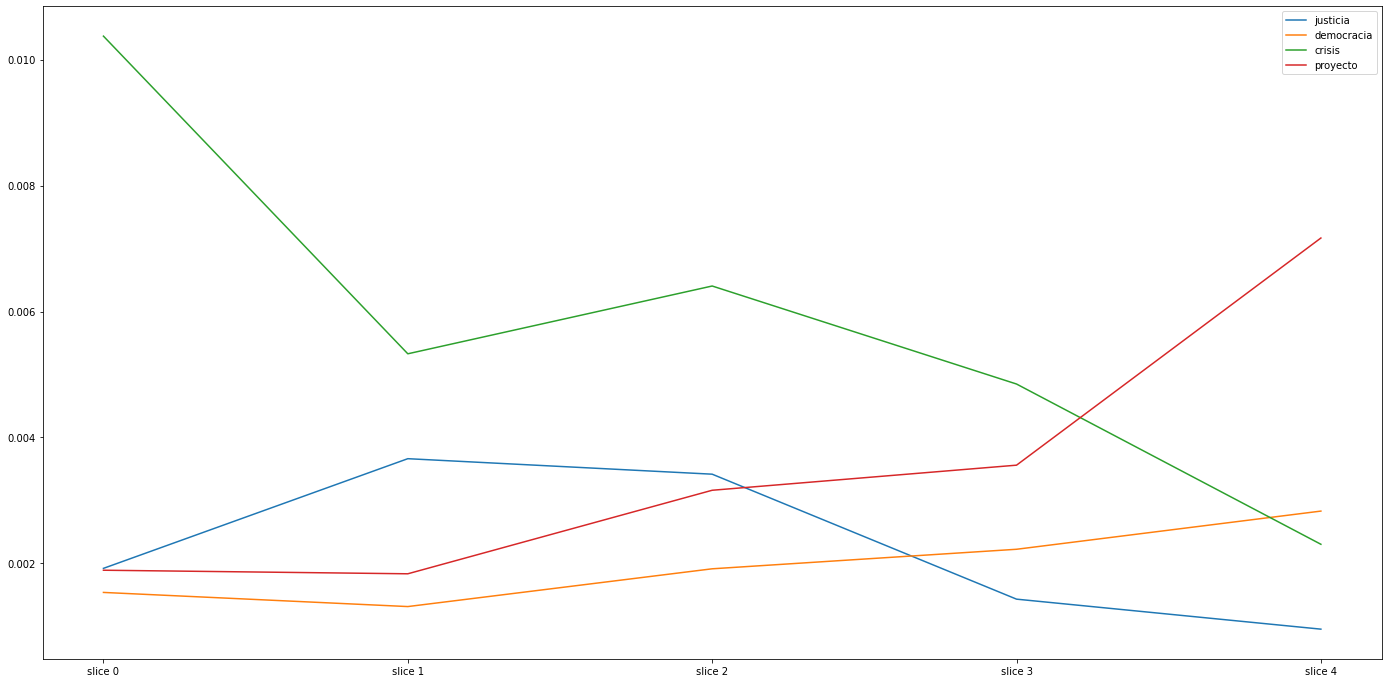

In [98]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

df=pd.DataFrame({'xvalues': xvalues1, 'yvalues': yvalues1 })
plt.plot( 'xvalues', 'yvalues', data=df, label="justicia")

df=pd.DataFrame({'xvalues': xvalues2, 'yvalues': yvalues2 })
plt.plot( 'xvalues', 'yvalues', data=df, label="democracia")

df=pd.DataFrame({'xvalues': xvalues4, 'yvalues': yvalues4 })
plt.plot( 'xvalues', 'yvalues', data=df, label="crisis")

df=pd.DataFrame({'xvalues': xvalues5, 'yvalues': yvalues5 })
plt.plot( 'xvalues', 'yvalues', data=df, label="proyecto")

ax.legend()
plt.show()

#### 5.2 Exploración de los tópicos

In [82]:
table=[]
for i in range(5):
    row=["slice "+str(i)]
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=35)
    for keyword in keywords:
        row.append(str(keyword[0])+", "+str(round(keyword[1],3)))
    table.append(row)

In [83]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

slice 0,"derechos, 0.018","humanos, 0.014","personas, 0.011","informe, 0.008","casos, 0.008","uso, 0.008","violaciones, 0.007","caso, 0.007","lugar, 0.007","octubre, 0.006","víctimas, 0.006","años, 0.006","manifestaciones, 0.005","violencia, 0.005","parte, 0.005","información, 0.005","comuna, 0.005","lesiones, 0.005","investigación, 0.005","delitos, 0.004","funcionarios, 0.004","respecto, 0.004","incendio, 0.004","momento, 0.004","delito, 0.004","manifestantes, 0.004","situación, 0.004","vida, 0.003","seguridad, 0.003","homicidio, 0.003","hechos, 0.003","país, 0.003","antecedentes, 0.003","acuerdo, 0.003","acción, 0.003"
slice 1,"personas, 0.013","$, 0.009","lugar, 0.007","comuna, 0.007","años, 0.007","octubre, 0.007","parte, 0.007","investigación, 0.006","funcionarios, 0.006","derechos, 0.006","personal, 0.005","momento, 0.005","antecedentes, 0.005","caso, 0.005","manifestaciones, 0.005","uso, 0.005","violaciones, 0.005","situación, 0.005","joven, 0.005","manifestantes, 0.005","incendio, 0.004","muerte, 0.004","casos, 0.004","información, 0.004","hecho, 0.004","humanos, 0.004","perdigones, 0.004","hechos, 0.004","embargo, 0.004","acuerdo, 0.004","carabineros, 0.003","manifestación, 0.003","calle, 0.003","violencia, 0.003","vida, 0.003"
slice 2,"personas, 0.016","parte, 0.008","octubre, 0.008","derechos, 0.007","manifestaciones, 0.007","funcionarios, 0.007","años, 0.006","información, 0.006","carabineros, 0.006","hecho, 0.005","situación, 0.005","investigación, 0.005","antecedentes, 0.005","hechos, 0.005","delito, 0.005","delitos, 0.005","joven, 0.004","familia, 0.004","comuna, 0.004","respecto, 0.004","caso, 0.004","violencia, 0.004","fiscal, 0.004","casos, 0.004","acuerdo, 0.004","interior, 0.004","autoridades, 0.004","denuncias, 0.004","violaciones, 0.004","momento, 0.004","querellas, 0.004","acciones, 0.004","país, 0.004","calle, 0.003","balines, 0.003"
slice 3,"personas, 0.017","años, 0.011","parte, 0.008","funcionarios, 0.007","vida, 0.007","derechos, 0.007","respecto, 0.006","antecedentes, 0.006","hecho, 0.005","hechos, 0.005","investigación, 0.005","comuna, 0.005","denuncias, 0.005","lesiones, 0.004","información, 0.004","fiscal, 0.004","momento, 0.004","delitos, 0.004","violencia, 0.004","autoridades, 0.004","caso, 0.004","delito, 0.004","manifestaciones, 0.004","situación, 0.004","acuerdo, 0.004","octubre, 0.004","familia, 0.004","uso, 0.004","personal, 0.004","persona, 0.004","cuenta, 0.004","organismo, 0.003","embargo, 0.003","días, 0.003","horas, 0.003"
slice 4,"años, 0.013","investigación, 0.013","familia, 0.011","fiscal, 0.01","delito, 0.01","parte, 0.008","antecedentes, 0.008","hecho, 0.007","delitos, 0.007","trabajo, 0.007","cuenta, 0.006","víctima, 0.006","personas, 0.006","respecto, 0.005","obesidad, 0.005","momento, 0.005","víctimas, 0.005","contra, 0.005","homicidio, 0.005","casa, 0.005","comuna, 0.005","casos, 0.005","lesiones, 0.004","vehículo, 0.004","caso, 0.004","justicia, 0.004","vida, 0.004","padre, 0.004","violencia, 0.004","información, 0.004","policía, 0.004","horas, 0.004","autoridades, 0.004","bala, 0.004","embargo, 0.004"


In [84]:
keyword="perdigones"
topic=1
xvalues1=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues1=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues1.append(newValue)

('perdigones', 0.001920706736095383)
('perdigones', 0.0036628701676456286)
('perdigones', 0.0034167390845980337)
('perdigones', 0.001431523359435553)
('perdigones', 0.0009550357847753437)


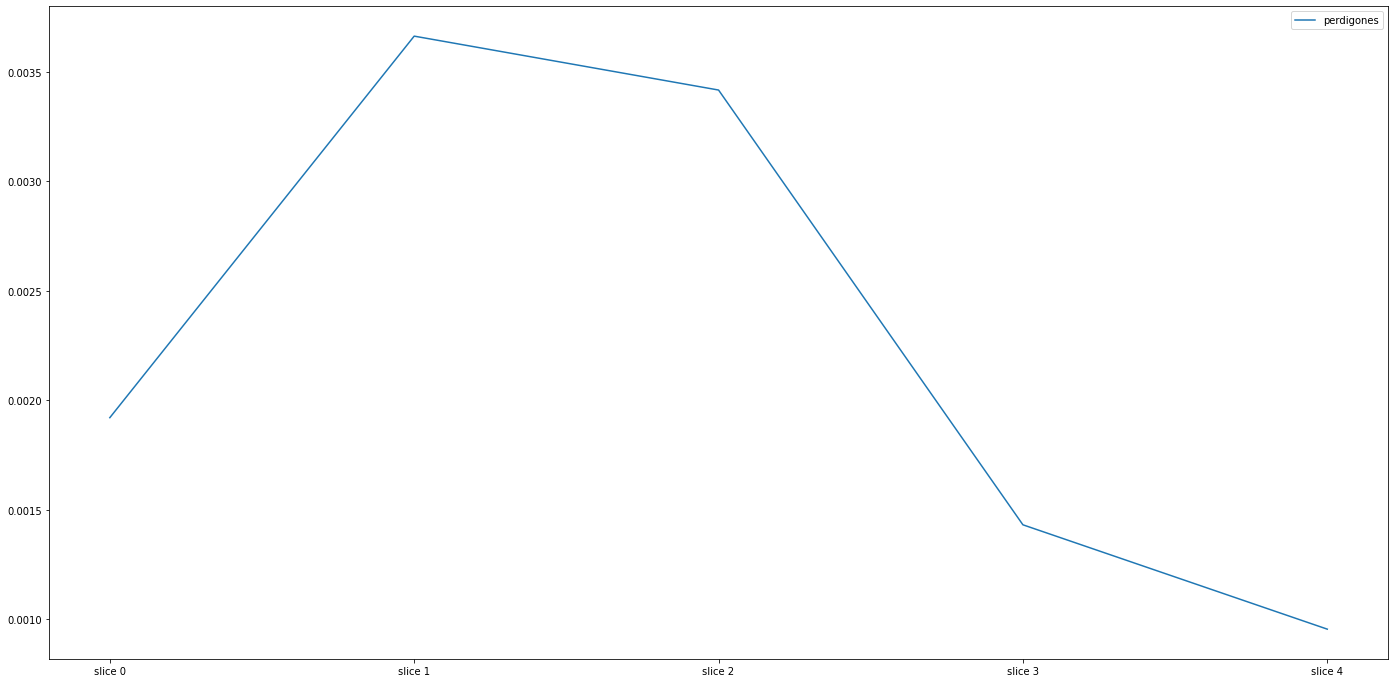

In [85]:
# libraries and data
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df=pd.DataFrame({'xvalues': xvalues1, 'yvalues': yvalues1 })
plt.plot( 'xvalues', 'yvalues', data=df, label="perdigones")

ax.legend()
plt.show()

- Topico 0 = "Delitos"
- Topico 1 = "Manifestaciones"
- Topico 2 = "Chile"
- Topico 3 = "Derechos humanos"
- Topico 4 = "Protestas / Ataques / Saqueos"
- Topico 5 = "Palabras del Presidente y políticos"
- Topico 6 = "Seguridad"
- Topico 7 = "Economía / Precio"